In [106]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as GMM
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.stats import kstest, anderson
import math
import seaborn as sns; sns.set()
import progressbar as pb
import time 
from scipy.sparse import csgraph

In [107]:
pnas_data1 = pd.read_csv('/home/jaeweon/research/data/pnas_data1.csv')
pnas_data2 = pd.read_csv('/home/jaeweon/research/data/pnas_data2.csv')
raw = pd.read_excel('/home/jaeweon/research/data/raw.xlsx', encoding = 'ISO-8859-1')
raw_corrected = pd.read_csv('/home/jaeweon/research/data/seshat_corrected.csv', encoding = 'ISO-8859-1')

In [108]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [109]:
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']

In [68]:
class progress_timer:

    def __init__(self, n_iter, description="Something"):
        self.n_iter         = n_iter
        self.iter           = 0
        self.description    = description + ': '
        self.timer          = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, maxval=self.n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()


In [9]:
# Check if XX^T, where X is the data matrix, is positive semidefinite 

def is_pos_def(x):
    """
    Check if the matrix is positive semidefinite 
    """
    return np.all(np.linalg.eigvals(x) > 0)

transposed_pnas1 = np.transpose(filtered_pnas1)
sym_mat = np.matmul(filtered_pnas1, transposed_pnas1)
print(is_pos_def(sym_mat)) # false -> is not positive semidefinite 

NameError: name 'filtered_pnas1' is not defined

In [11]:
def svd(data):
    """
    perform singular value decomposition on the given data matrix
    """
    #center the data
    mean = np.mean(data, axis=0)
    data -= mean
    
    P, D, Q = np.linalg.svd(filtered_pnas1, full_matrices=False)
#     col_vec = np.abs(Q)/sum(np.abs(Q))*100
#     first_col = col_vec[:, 0]

#     col_vec = np.abs(Q)/sum(np.abs(Q))*100
#     D = D/sum(D)*100  # percentage of singular values 
    
    return P, D, Q

In [12]:
def pca(data, num_components):
    """
    perform PCA on the given data matrix
    """
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components= num_components)
    pca.fit(X)
    X_pca = pca.transform(X)
    variance = pca.explained_variance_
    X_new = pca.inverse_transform(X_pca)
    return X_new, variance

In [13]:
# SVD on the original data matrix. 
filtered_pnas1 = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)

P, D, Q = svd(filtered_pnas1)
reconstruct = np.matmul(np.matmul(P, np.diag(D)), Q)
print(np.std(filtered_pnas1), np.std(reconstruct), np.std(filtered_pnas1-reconstruct))
print(D)

1.0 1.0 1.47612302175e-15
[ 239.87612126   66.72062661   58.88074418   53.47763958   42.72997322
   41.23965724   35.77532382   27.53983673   25.22158047]


In [555]:
# covariance and check for orthonormality

filtered_pnas1 = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
P, D, Q = svd(filtered_pnas1)

product = np.dot(Q.T,Q)
np.fill_diagonal(product,0)
if (product.any() == 0): 
    raise Exception('not orthogonal') #check orthogonality of the matrix to ensure that PCs are orthogonal

D = [x**2/sum([y**2 for y in D]) for x in D] # variance for each vector 
data = np.matmul(filtered_pnas1, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix
num_bins = 100
mu = 0 # mean (data is centered)

# covariance matrix 
print(np.cov(Q.T))
X = data[:,0]; Y = data[:,1]
X = np.stack((X, Y), axis=0)
print("Covariance matrix for the first two components: ", np.cov(X))
print("Covariance matrix for the entire dataset: ", np.cov(data, rowvar= False))


[[ 0.1121876  -0.00773236  0.02070871  0.0079736   0.00165385 -0.00492465
   0.01463674 -0.00203276  0.02529468]
 [-0.00773236  0.12033348  0.01249782  0.00481211  0.00099811 -0.00297205
   0.00883335 -0.00122678  0.01526548]
 [ 0.02070871  0.01249782  0.09152849 -0.01288774 -0.00267311  0.00795972
  -0.02365738  0.00328555 -0.04088383]
 [ 0.0079736   0.00481211 -0.01288774  0.12003775 -0.00102925  0.00306478
  -0.00910895  0.00126506 -0.01574175]
 [ 0.00165385  0.00099811 -0.00267311 -0.00102925  0.12478652  0.00063568
  -0.00188933  0.00026239 -0.00326508]
 [-0.00492465 -0.00297205  0.00795972  0.00306478  0.00063568  0.12310713
   0.00562586 -0.00078132  0.00972241]
 [ 0.01463674  0.00883335 -0.02365738 -0.00910895 -0.00188933  0.00562586
   0.10827916  0.0023222  -0.02889635]
 [-0.00203276 -0.00122678  0.00328555  0.00126506  0.00026239 -0.00078132
   0.0023222   0.12467749  0.00401315]
 [ 0.02529468  0.01526548 -0.04088383 -0.01574175 -0.00326508  0.00972241
  -0.02889635  0.00401

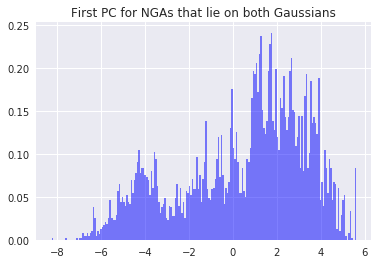

In [56]:
# covariance and mean for GMM model 

# filtered_pnas1 = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
filtered_pnas1 = pnas_data1.loc[:, features].values
P, D, Q = svd(filtered_pnas1)

product = np.dot(Q.T,Q)
np.fill_diagonal(product,0)
if (product.any() == 0): 
    raise Exception('not orthogonal') #check orthogonality of the matrix to ensure that PCs are orthogonal

D = [x**2/sum([y**2 for y in D]) for x in D] # variance for each vector 
data = np.matmul(filtered_pnas1, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix


# retrive 25 polities from the lowest and the highest in the two Gaussian distrubitons 
# from the first principal component
subset_features = ['NGA', 'PolID', 'Time']

idx_data = sorted(range(len(data[:,0])), key = lambda i: data[:,0][i])
re_idx = pnas_data1.reindex(idx_data)
unique = re_idx.drop_duplicates(subset = subset_features) #drop duplicates from imputation

# lowest = unique.head(25).loc[:,subset_features]
# highest = unique.tail(25).loc[:,subset_features]
# lowest.to_csv('lowest_25.csv')
# highest.to_csv('highest_25.csv')

# # retrive 25 polities from the left and right side of the transition axis (~-0.9)
# lf_data = [idx for idx in unique.index.values if data[:,0][idx] <= -0.9][-25:]
# rt_data = [idx for idx in unique.index.values if data[:,0][idx] > -0.9][:25]

# lf = unique.loc[lf_data].loc[:, subset_features]
# rt = unique.loc[rt_data].loc[:, subset_features]
# lf.to_csv('left_transition.csv')
# rt.to_csv('right_transition.csv')

#Gaussian Mixture Model 
#fit GMM
gmm = GMM(n_components=2)
gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

# Evaluate GMM
gmm_x = np.linspace(-6, 6, 200)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

# mean and covariance for each component
gauss_one = gmm.weights_[0] #weight for gaussian distribution
gauss_two = gmm.weights_[1] #weight for gaussian distribution 

prob_distr = gmm.predict_proba(X=np.expand_dims(sorted(data[:,0]), 1))
lower = list()
higher = list()

# compute which datapoints belong in the lower and higher gaussian
for idx in range(len(prob_distr)):
    if gmm.weights_[0] < gmm.weights_[1]:
        if prob_distr[idx][0] >= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])
    else:
        if prob_distr[idx][0] <= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])

lower = [i for i in unique.index.values for j in lower if i==j]
higher = [i for i in unique.index.values for j in higher if i==j]

gauss1_pol = pnas_data1.loc[lower[-25:]].loc[:, subset_features]
gauss2_pol = pnas_data1.loc[higher[:25]].loc[:, subset_features]

#indicate the origin of each row 
gauss1_pol['origin'] = 'Gauss1'
gauss2_pol['origin'] = 'Gauss2'

#transition 
trans = gauss1_pol.append(gauss2_pol).sort_values(by=['NGA', 'Time'])
# trans.to_csv('transition.csv')

# return polities that lie in both Gaussians
lower_df = unique.loc[lower]
higher_df = unique.loc[higher]
unique_pol = [i for i in unique.PolID.unique().tolist() if (i in lower_df.PolID.unique().tolist() 
                                                            and i in higher_df.PolID.unique().tolist())]
unique_nga = [i for i in unique.NGA.unique().tolist() if (i in lower_df.NGA.unique().tolist()
                                                         and i in higher_df.NGA.unique().tolist())]


nga_gauss = pnas_data1.loc[pnas_data1['NGA'].isin(unique_nga)]
both_gauss = np.take(data[:,0], nga_gauss.index.values)
num_bins = 200

n, bins, patches = plt.hist(both_gauss, num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('First PC for NGAs that lie on both Gaussians')
plt.legend()
plt.show()
plt.close()


In [220]:
# comparison between the main principal axis from univariate Gaussian with two principal axes from 
# bivariate Gaussian

data_mat = pnas_data1.loc[:, features].values

# univariate Gaussian
gmm1 = GMM(n_components=1).fit(data_mat)
cov = gmm1.covariances_[0]

# bivariate Gaussian
gmm2 = GMM(n_components=2).fit(data_mat)
cov_comp1 = gmm2.covariances_[0]
cov_comp2 = gmm2.covariances_[1]

# eigenvectors for the covariance matrices
eig_val1, eig_vec1 = np.linalg.eigh(cov)
eig_val_comp1, eig_vec_comp1 = np.linalg.eigh(cov_comp1)
eig_val_comp2, eig_vec_comp2 = np.linalg.eigh(cov_comp2)

def main_axis(eig_val, eig_vec):
    """
    Given eigenvalues and corresponding eigenvectors, find the principal axis (i.e. eigenvectors that correspond
    to the largest eigenvalue). Return the eigenvector that represents the principal axis as well as the 
    percentage representation of the corresponding eigenvalue
    """
    idx = eig_val.tolist().index(max(eig_val))
    main_vec = eig_vec[:,idx]
    main_eig = eig_val[idx]/sum(eig_val)
    return main_eig, main_vec

gmm1_eig, gmm1_axis = main_axis(eig_val1, eig_vec1)
gmm2_eig_comp1, gmm2_axis_comp1 = main_axis(eig_val_comp1, eig_vec_comp1)
gmm2_eig_comp2, gmm2_axis_comp2 = main_axis(eig_val_comp2, eig_vec_comp2)

def angle(vec1, vec2):
    """
    Given two vectors, compute the angle between the vectors
    """
    cos_vec = np.inner(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    angle = math.acos(cos_vec)
    in_deg = math.degrees(angle)
    if in_deg >= 90:
        return (180-in_deg)
    return in_deg

print(gmm2_axis_comp1, gmm2_axis_comp2)
gmm2 = angle(gmm2_axis_comp1, gmm2_axis_comp2)
comp1 = angle(gmm1_axis, gmm2_axis_comp1)
comp2 = angle(gmm1_axis, gmm2_axis_comp2)

print("percentage representation of univariate Gaussian eigenvalue: ", gmm1_eig*100, '%')
print("percentage representation of the first component of bivariate Gaussian eigenvalue: ", gmm2_eig_comp1*100, '%')
print("percentage representation of the first component of bivariate Gaussian eigenvalue: ", gmm2_eig_comp2*100, "%\n")

print("angle between two components of bivariate Gaussian : ", gmm2)
print("angle between main axis and first component of bivariate Gaussian : ", comp1)
print("angle between main axis and second component of bivariate Gaussian : ", comp2)

    

[-0.51771982 -0.55615697 -0.26102255 -0.30805289 -0.06050056 -0.04266915
 -0.10136025 -0.07099023 -0.48870417] [-0.48233833 -0.44029203 -0.3404176  -0.47117983 -0.04161751 -0.03446429
  0.00469575 -0.00890155 -0.48226238]
percentage representation of univariate Gaussian eigenvalue:  78.867339778 %
percentage representation of the first component of bivariate Gaussian eigenvalue:  55.5341952272 %
percentage representation of the first component of bivariate Gaussian eigenvalue:  62.4838660561 %

angle between two components of bivariate Gaussian :  14.437401690684622
angle between main axis and first component of bivariate Gaussian :  10.669258358691183
angle between main axis and second component of bivariate Gaussian :  9.48582719163112


In [ ]:
# Fit bivariate Gaussian on the original data and compute confidence intervals, error bars using bootstrapping
data_mat = pnas_data1.loc[:, features].values
pt = progress_timer(description= 'boostrapping', n_iter=5000)

def eig(mat):
    """
    Given a list of two matrices, compute the largest eigenvalues' proportion over sum of all eigenvalues as well 
    as the corresponding eigenvectors
    """
    eig_val1, eig_vec1 = np.linalg.eig(mat[0])
    eig_val2, eig_vec2 = np.linalg.eig(mat[1])
    
    # proportion of largest eigenvalue with respect to each component
    val1 = max(eig_val1)/sum(eig_val1)
    val2 = max(eig_val2)/sum(eig_val2)
    
    # eigenvector corresponding to the largest eigenvalue with respect to each component
    vec1 = eig_vec1[:,np.argmax(eig_val1)]
    vec2 = eig_vec2[:,np.argmax(eig_val2)]
        
    assert np.array_equal(vec1, eig_vec1[:,np.argmax(eig_val1)])
    assert np.array_equal(vec2, eig_vec2[:,np.argmax(eig_val2)])
    
    return val1, val2, vec1, vec2

#Gaussian Mixture Model 
#fit GMM
gmm = GMM(n_components=2).fit(data_mat)
probs = gmm.predict_proba(data_mat)

val1, vec1 = np.linalg.eig(gmm.covariances_[0])
val2, vec1 = np.linalg.eig(gmm.covariances_[0])


def weight_set(gmm):
    """
    Given gmm model, set the component with larger weight to be the first component and the component with
    smaller weight to be the second component
    """
    
    val1, val2, vec1, vec2 = eig(gmm.covariances_) #eigenvalues and eigenvecotrs for covariance matrices

    if gmm.weights_[0] > gmm.weights_[1]:
        mean_one = gmm.means_[0]
        mean_two = gmm.means_[1]
        eig_val1 = val1
        eig_val2 = val2
        eig_vec1 = vec1
        eig_vec2 = vec2
    else:
        mean_one = gmm.means_[1]
        mean_two = gmm.means_[0]
        eig_val1 = val2
        eig_val2 = val1
        eig_vec1 = vec2
        eig_vec2 = vec1
        
    return mean_one, mean_two, eig_val1, eig_val2, eig_vec1, eig_vec2

mean_one, mean_two, eig_val1, eig_val2, eig_vec1, eig_vec2 = weight_set(gmm)
orig_angle = angle(eig_vec1, eig_vec2) # angle between the main eigenvectors 

# boostrapping for mean of gmm
def bstr(data, n=5000):
    """
    Given data matrix, perform bootstrapping by collecting n samples (default = 5000) and return the 
    error rate for the mean of the data. Assume that the given data matrix is numpy array
    """
    mean_vecs_one = list() #hold mean vectors for component 1
    mean_vecs_two = list() #hold mean vectors for component 2
    
    perc_one = list() # hold proprtion of largest eigenvalues for component 1
    perc_two = list() # hold propotion of largest eigenvalues for component 2
    
    vec_one = list() # hold eigenvectors for component 1
    vec_two = list() # hold eigenvectors for component 2
    
    angles = list() # hold angle between main eigenvectors of two Gaussian component
    
    for i in range(n):
    
        resampled_mat = data[np.random.randint(0, data.shape[0])]
        
        for j in range(data.shape[0]-1):
            resample = np.random.randint(0, data.shape[0])
            data_resample = data[resample]
            resampled_mat = np.vstack((resampled_mat, data_resample))
    
        assert resampled_mat.shape == data.shape # check if the resampled matrix has same dimension as data matrix
        
        gmm = GMM(n_components=2).fit(resampled_mat)
    
        mean_one, mean_two, eig_val1, eig_val2, eig_vec1, eig_vec2 = weight_set(gmm)
        
        mean_vecs_one.append(mean_one)
        mean_vecs_two.append(mean_two)
        perc_one.append(eig_val1)
        perc_two.append(eig_val2)
        vec_one.append(eig_vec1)
        vec_two.append(eig_vec2)
        angles.append(angle(eig_vec1, eig_vec2))
        
        pt.update()
        
    mean_one = np.mean(mean_vecs_one, axis=0)
    mean_two = np.mean(mean_vecs_two, axis=0)
    
    perc_one = sum(perc_one)/len(perc_one)
    perc_two = sum(perc_two)/len(perc_two)
    
    vec_one = np.mean(vec_one, axis=0)
    vec_two = np.mean(vec_two, axis=0)
    
    bstr_angle = sum(angles)/len(angles)
    
    return mean_one, mean_two, perc_one, perc_two, vec_one, vec_two, bstr_angle

def vec_error(original, bst):
    """
    Given two n-dim vectors, one from the original and one from bootstrapping, compute the relative error
    between these two vectors
    """
    assert original.shape == bst.shape 
    
    return [abs(i-j)/(i) for i, j in zip(original, bst)]

def error(val1, val2):
    """
    Given two values, compute the relative error
    """
    return abs(val1-val2)/val1

def angle_error(ang1, ang2):
    """
    Given two angles, compute the relative error
    """
    if ang1 >= 90 and ang2 < 90:
        return abs((180-ang1)-ang2)/(180-ang1)
    elif ang1 < 90 and ang2 >= 90:
        return abs(ang1-(180-ang2))/(180-ang2)
    else:
        return abs(ang1-ang2)/ang1

mean_one, mean_two, perc_one, perc_two, vec_one, vec_two, bstr_angle = bstr(data_mat)
pt.finish()

print("first mean_vector error : ", error(mean_one, bootstrapped_one))
print("second mean_vector error : ", error(mean_two, bootstrapped_two))

print("error for eigenvalue for the first component: ", error(perc_one, eig_val1))
print("error for eigenvalue for the second component: ", error(perc_two, eig_val2))

print("error for eigenvector for the first component: ", vec_error(vec_one, eig_vec1))
print("error for eigenvector for the first component: ", vec_error(vec_two, eig_vec2))

print("error for angle between the eigenvectors from each component: ", angle_error(orig_angle, bstr_angle))



boostrapping:  14% ||                                          | ETA:   0:17:00

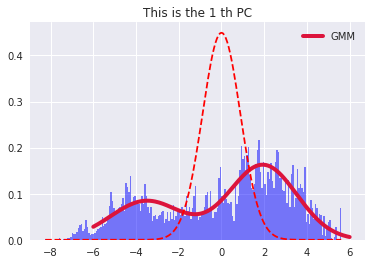

Using kolmogrov-Smirnov test, p value is  0.0 

Using kolmogrov-Smirnov test, statistic value is  0.324975137595


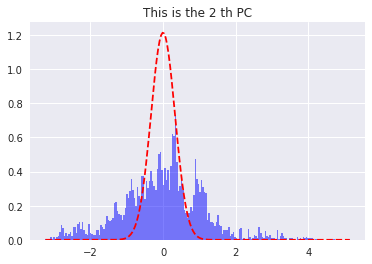

Using kolmogrov-Smirnov test, p value is  1.57932618837e-07 

Using kolmogrov-Smirnov test, statistic value is  0.0314257084771


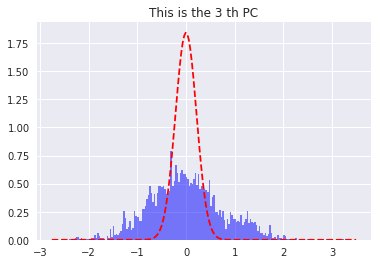

Using kolmogrov-Smirnov test, p value is  2.24048780129e-52 

Using kolmogrov-Smirnov test, statistic value is  0.0849910759757


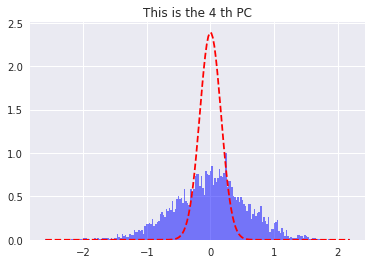

Using kolmogrov-Smirnov test, p value is  8.25709730028e-129 

Using kolmogrov-Smirnov test, statistic value is  0.133608310445


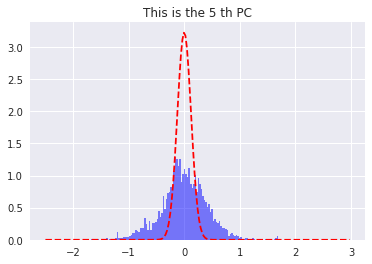

Using kolmogrov-Smirnov test, p value is  0.0 

Using kolmogrov-Smirnov test, statistic value is  0.212473438887


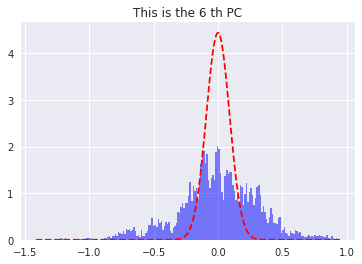

Using kolmogrov-Smirnov test, p value is  0.0 

Using kolmogrov-Smirnov test, statistic value is  0.269343577618


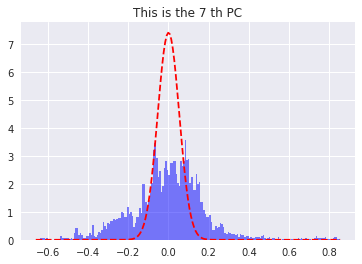

Using kolmogrov-Smirnov test, p value is  0.0 

Using kolmogrov-Smirnov test, statistic value is  0.345771126373


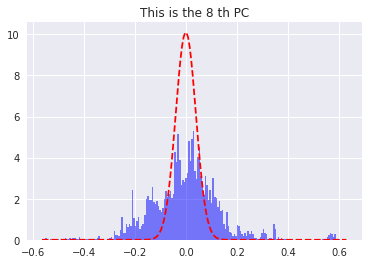

Using kolmogrov-Smirnov test, p value is  0.0 

Using kolmogrov-Smirnov test, statistic value is  0.381407411208


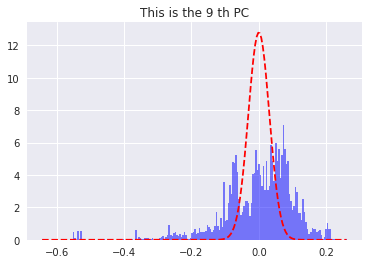

Using kolmogrov-Smirnov test, p value is  0.0 

Using kolmogrov-Smirnov test, statistic value is  0.414362280149


In [165]:
# histogram and gaussian mixture model  
# filtered_pnas1 = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
filtered_pnas1 = pnas_data1.loc[:, features].values
P, D, Q = svd(filtered_pnas1)

D = [x**2/sum([y**2 for y in D]) for x in D] # variance for each vector 
data = np.matmul(filtered_pnas1, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix
num_bins = 200
mu = 0 # mean (data is centered)

#fit GMM
gmm = GMM(n_components=2)
gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

# Evaluate GMM
gmm_x = np.linspace(-6, 6, 200)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

# mark datapoints by their respective threshold on the first principal component
mark = list()
for i in range(len(data[:,0])):
    if data[:,0][i] < -0.9:
        mark.append(1)
    else:
        mark.append(0)

# the histogram/gaussian mixture model of the data
for i in range(9):
    if i == 0:
        fig, ax = plt.subplots()
        ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")

    sigma = math.sqrt(D[i]) #standard deviation of the dataset
    n, bins, patches = plt.hist(data[:,i], num_bins, normed=1, facecolor='blue', alpha=0.5)
    y = mlab.normpdf(bins, mu, sigma)
    plt.plot(bins, y, 'r--')

    plt.title('This is the %s th PC'% str(int(i)+1))
    plt.legend()
    plt.show()
    plt.close()
    
    stat, p_val = kstest(data[:,i], 'norm')
    print("Using kolmogrov-Smirnov test, p value is ", p_val, '\n')
    print("Using kolmogrov-Smirnov test, statistic value is ", stat)
    
    
    


In [508]:
#20 imputed sets combined
X = pnas_data1.loc[:, features].values
X = StandardScaler().fit_transform(X)
P, D, Q = svd(X)
pca = PCA(n_components=9)
pca.fit(X)
X_pca = pca.transform(X)
X_new = pca.inverse_transform(X_pca)

print("components matrix : ", pca.components_, "\n")
print("variance : ", pca.explained_variance_, "\n")
print("singular values : ", pca.singular_values_, "\n")

print('singular value matrix', D)
print('column mat', Q)



components matrix :  [[-0.35184449 -0.32197153 -0.33691204 -0.34112479 -0.33297665 -0.33286962
  -0.32848139 -0.34938387 -0.3016939 ]
 [-0.33885801 -0.47466313 -0.37363756 -0.20478612  0.12918721  0.16850614
   0.42336133  0.32350207  0.38646567]
 [ 0.1238707   0.3177609  -0.09256578 -0.05839083 -0.46790073 -0.47255936
   0.13114705 -0.05112575  0.64003852]
 [-0.01439807 -0.34044785  0.14428373  0.21732156  0.11141488  0.25005825
  -0.55642333 -0.33309761  0.56598424]
 [-0.04629945  0.41527587 -0.59961256  0.03693777  0.6181868  -0.16061037
  -0.18502999 -0.1257437   0.08065053]
 [ 0.17002253  0.29532094 -0.01593358 -0.75887495 -0.08723973  0.51545042
  -0.15627264 -0.03040533  0.09532722]
 [ 0.12775423 -0.21179927  0.46073737 -0.4536754   0.49961207 -0.47512205
   0.1278661  -0.14931267  0.08199045]
 [-0.77555646  0.34680388  0.37040678 -0.0437141   0.0403597  -0.05254957
  -0.21367566  0.28614715  0.08484874]
 [-0.31139876  0.1713247   0.09071833  0.0779134   0.00927566  0.23446699
 

In [23]:
#try PCA for each imputed dataset. Result was roughly the same across all 20 imputed dataset
for i in range(20):
    imputed_set = pnas_data1[pnas_data1.irep == (i+1)]
    X = imputed_set.loc[:, features].values
    
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=9)
    pca.fit(X)
    print(str(i+1) + 'th imputed set', pca.explained_variance_)


1th imputed set [ 6.95456595  0.53898619  0.41781449  0.33829053  0.23192585  0.20515738
  0.15098684  0.10225482  0.08180972]
2th imputed set [ 6.99857018  0.51004731  0.41538579  0.35553494  0.22283908  0.20418307
  0.1531763   0.08624197  0.07581313]
3th imputed set [ 6.97692367  0.54300461  0.41921652  0.34468072  0.21844017  0.20236374
  0.15774642  0.08517682  0.0742391 ]
4th imputed set [ 6.9711295   0.55692525  0.42193305  0.34617265  0.2133972   0.20131161
  0.15126108  0.09177529  0.06788614]
5th imputed set [ 6.94239471  0.56425187  0.41822403  0.33146201  0.2318954   0.21130869
  0.15477703  0.09264955  0.07482847]
6th imputed set [ 6.96897315  0.52416112  0.41538604  0.35202733  0.21803114  0.20760835
  0.16552746  0.09392112  0.07615607]
7th imputed set [ 6.9648173   0.57198529  0.40864104  0.34103006  0.21854222  0.20051266
  0.14324606  0.09273841  0.08027871]
8th imputed set [ 6.99231885  0.51106865  0.42915113  0.34048573  0.22857671  0.20521261
  0.15277528  0.087487

[[-0.35184449 -0.32197153 -0.33691204 -0.34112479 -0.33297665 -0.33286962
  -0.32848139 -0.34938387 -0.3016939 ]
 [-0.33885801 -0.47466313 -0.37363756 -0.20478612  0.12918721  0.16850614
   0.42336133  0.32350207  0.38646567]]
[-2.78272367 -2.54645969] [  4.29286236e-16   3.29097994e-16]
[-0.7454357  -1.04418615] [  4.29286236e-16   3.29097994e-16]


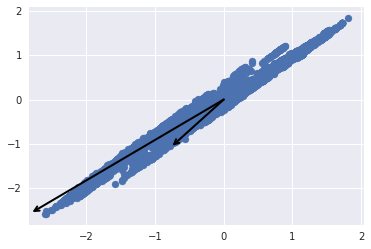

In [541]:
# plot 3d scatter plot by using 3 PCs

#draw vectors of principal component axis 
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    print(v1, v0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

X = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
X_new = pca.inverse_transform(X_pca)

# P, D, Q = svd(filtered_pnas1)
# data = np.matmul(filtered_pnas1, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix

plt.scatter(X_new[:, 0], X_new[:, 1])
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector  * 3 * np.sqrt(length)
    draw_vector(pca.mean_[:2], (pca.mean_ + v)[:2])
plt.show()
plt.close()

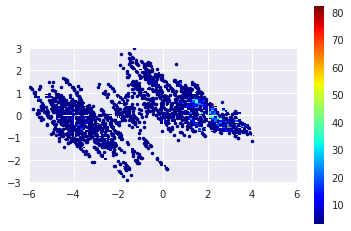

In [466]:
# pca density map
# X = pnas_data1.loc[:, features].values
# X = StandardScaler().fit_transform(X)
# pca = PCA(n_components=9)
# pca.fit(X)
# X_pca = pca.transform(X)
# X_new = pca.inverse_transform(X_pca)


#histogram definition
xyrange = [[-6,6],[-3,3]] # data range
bins = [100,100] # number of bins
thresh = 3  #density threshold

#data definition
N = 1e5;
# plot 3d scatter plot by using 3 PCs

#normality test 
filtered_pnas1 = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
pca = PCA(n_components=2)
pca.fit(filtered_pnas1)
X_pca = pca.transform(filtered_pnas1)
X_new = pca.inverse_transform(X_pca)
P, D, Q = svd(filtered_pnas1)

# product = np.dot(Q.T,Q)
# np.fill_diagonal(product,0)
# if (product.any() == 0): 
#     raise Exception('not orthogonal') #check orthogonality of the matrix to ensure that PCs are orthogonal

data = np.matmul(filtered_pnas1, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix

fig = plt.figure()
X, Y = data[:, 0], data[:, 1]
X, Y = filtered_pnas1[:,0], filtered_pnas1[:, 1]
# X, Y = X_new[:,0], X_new[:, 0]
# X, Y= data[:, 0], np.full((len(data[:,0])), 0)


# histogram the data
hh, locx, locy = scipy.histogram2d(X, Y, range=xyrange, bins=bins)
posx = np.digitize(X, locx)
posy = np.digitize(Y, locy)

#select points within the histogram
ind = (posx > 0) & (posx <= bins[0]) & (posy > 0) & (posy <= bins[1])
hhsub = hh[posx[ind] - 1, posy[ind] - 1] # values of the histogram where the points are
xdat1 = X[ind][hhsub < thresh] # low density points
ydat1 = Y[ind][hhsub < thresh]
hh[hh < thresh] = np.nan # fill the areas with low density by NaNs

plt.imshow(np.flipud(hh.T),cmap='jet',extent=np.array(xyrange).flatten(), interpolation='none', origin='upper')
plt.colorbar()   
plt.plot(xdat1, ydat1, '.',color='darkblue')
plt.show()

In [510]:
#clear up all open figures

plt.close("all")

In [131]:
# list of split dataset based on timeframe as well as the entire dataset 
#(5 stages : ~-1500, -1500~0, 0~1000, 1000~1500, 1500~)

stage1 = pnas_data1.loc[pnas_data1['Time'] < -1500]
stage2 = pnas_data1.loc[(pnas_data1['Time'] < 0) & (pnas_data1['Time'] >= -1500)]
stage3 = pnas_data1.loc[(pnas_data1['Time'] < 1000) & (pnas_data1['Time'] >= 0)] 
stage4 = pnas_data1.loc[(pnas_data1['Time'] < 1500) & (pnas_data1['Time'] >= 1000)]
stage5 = pnas_data1.loc[pnas_data1['Time'] > 1500]

stages = [stage1, stage2, stage3, stage4, stage5, pnas_data1]

for i in range(6):
    stages[i] = stages[i].loc[:,features].values
    
    P, D, Q = svd(stages[i])
#     print("This is the " + str(i)+"th stage")
#     print("Singular values : ", D)
#     print("column vectors from SVD : ", Q[:,0])
    print('Q', Q)
    col_vec = np.abs(Q)
    col_vec = col_vec/sum(col_vec)*100
    print('col_vec', col_vec)
    break
    D = D/sum(D)*100  # percentage of singular values 
    stages[i] = [D, Q[:,0], col_vec[:,0]]
    


Q [[  4.89385612e-01   4.49640632e-01   3.23119140e-01   4.26346583e-01
    8.53371963e-02   8.15461018e-02   8.85622748e-02   1.18724690e-01
    4.86082920e-01]
 [ -2.51846886e-01  -3.97197061e-01  -1.86454588e-01  -1.28793298e-01
   -1.06927766e-02   7.15830286e-04   2.19596515e-02   1.30298601e-02
    8.52459830e-01]
 [  4.44025186e-02   6.58232200e-01  -2.81774557e-01  -6.69535773e-01
   -7.19820127e-02  -7.51653807e-02  -5.23953235e-03  -3.99570083e-02
    1.56934624e-01]
 [ -5.07771808e-01   3.86904252e-01  -5.14739685e-01   5.69755399e-01
    2.81916916e-03  -5.34621385e-02  -2.03475416e-03   3.11336388e-03
    3.84078440e-03]
 [  6.52877881e-01  -2.34145571e-01  -7.10933369e-01   9.80790899e-02
    2.01690453e-02  -8.99332811e-03   1.13336527e-02  -5.81595454e-03
   -5.68384924e-02]
 [  9.83369588e-02   1.60622651e-02   8.59828816e-02   1.26271367e-01
   -3.47863016e-01  -3.29372889e-01  -5.40272831e-01  -6.60638059e-01
    9.43492293e-02]
 [ -3.35315468e-02   4.01528850e-02  -

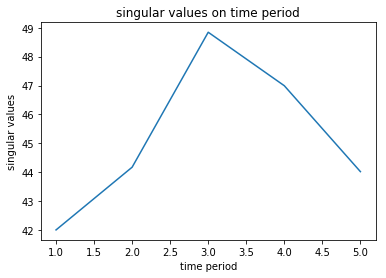

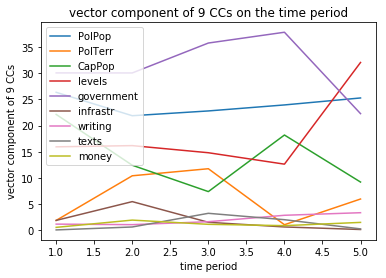

In [52]:
# PCA on timeframe 

# plot the Singular values based on time period 
sing_val = list()
for i in range(5):
    sing_val.append(stages[i][0][0]) #add singular values to sing_val array
    
plt.plot(range(1,6), sing_val ,label= "stage" + str(i+1))
plt.xlabel('time period')
plt.ylabel('singular values')
plt.title('singular values on time period')
plt.show()
plt.close()

#plot the change in the effect of each variables over time
feature_vec = list()

for i in range(9):
    vec_per = list() #list for the vectors of components
    
    for j in range(5): 
        vec_per.append(stages[j][2][i])
        
    plt.plot(range(1,6), vec_per ,label= features[i])
plt.xlabel('time period')
plt.ylabel('vector component of 9 CCs')
plt.title('vector component of 9 CCs on the time period')
plt.legend(features, loc='upper left')
plt.show()
plt.close()

In [67]:
# Identify the correlation between each variables based on the signs of the column vectors of SVD

for k in range(6):
    #initialize dataframe object 
    correlation = pd.DataFrame(index = features, columns = features)
    correlation = correlation.fillna(0)
    
    for i in range(9):
        for j in range(i+1, 9):
            
            if np.sign(stages[k][1][i]) == np.sign(stages[k][1][j]):
                correlation[features[i]][features[j]] = 1
                correlation[features[j]][features[i]] = 1
            else:
                correlation[features[i]][features[j]] = 0
                correlation[features[j]][features[i]] = 0
    
    #diagonal entries are correlated (same variables)
    for l in range(len(D)):
        correlation[features[l]][features[l]] = 1
    
    if k+1 < 6:
        print("stage" + str(k+1) + " correlation matrix \n", correlation)
    else:
        print("overall correlation matrix \n", correlation)
    
    
    
            
    


stage1 correlation matrix 
             PolPop  PolTerr  CapPop  levels  government  infrastr  writing  \
PolPop           1        0       0       1           0         1        1   
PolTerr          0        1       1       0           1         0        0   
CapPop           0        1       1       0           1         0        0   
levels           1        0       0       1           0         1        1   
government       0        1       1       0           1         0        0   
infrastr         1        0       0       1           0         1        1   
writing          1        0       0       1           0         1        1   
texts            0        1       1       0           1         0        0   
money            1        0       0       1           0         1        1   

            texts  money  
PolPop          0      1  
PolTerr         1      0  
CapPop          1      0  
levels          0      1  
government      1      0  
infrastr        0      1  
wr

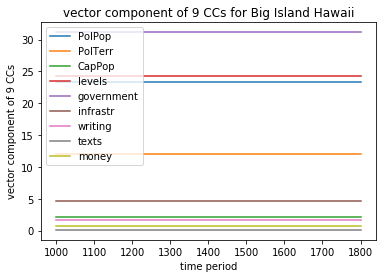

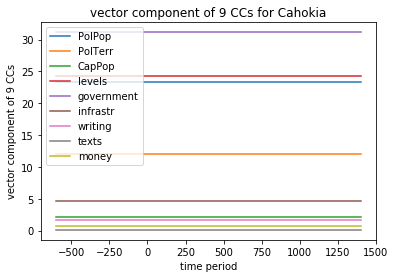

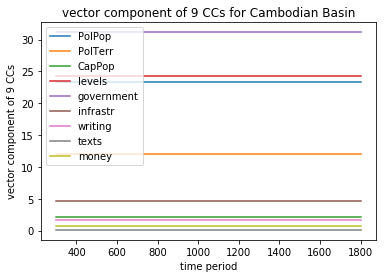

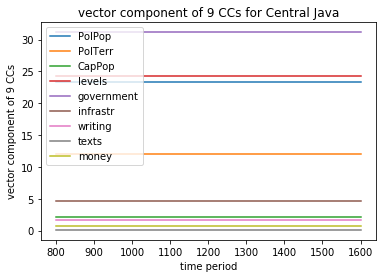

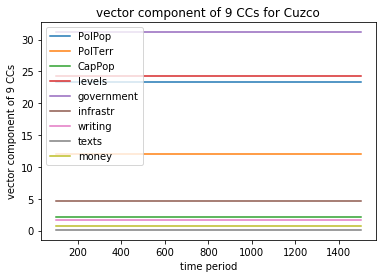

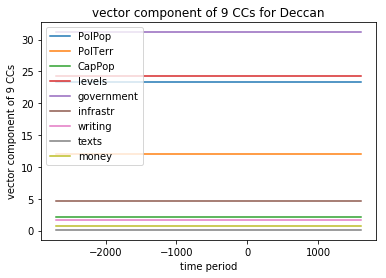

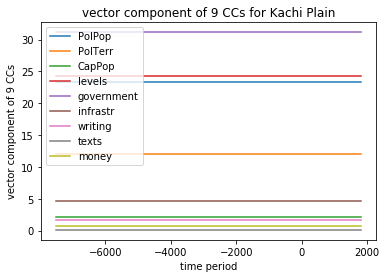

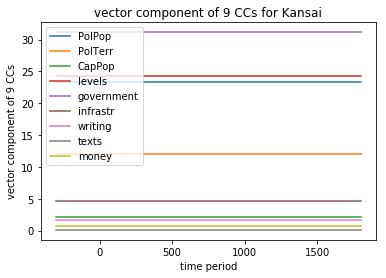

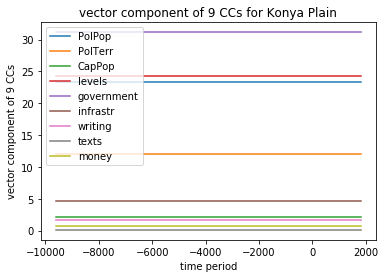

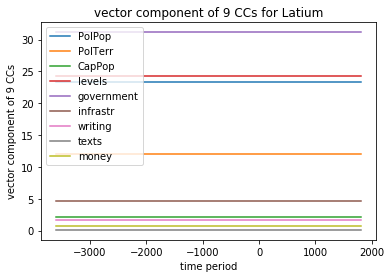

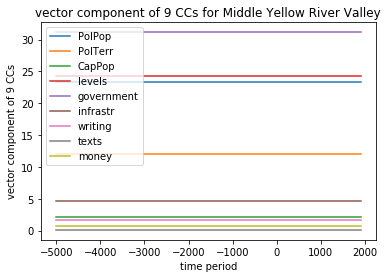

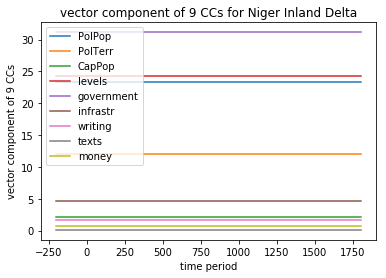

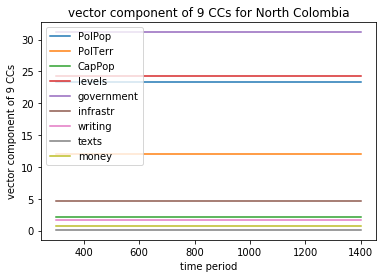

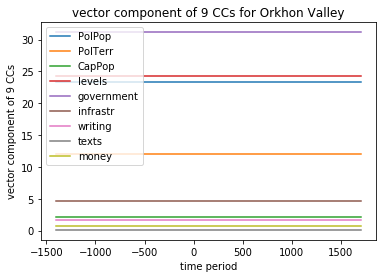

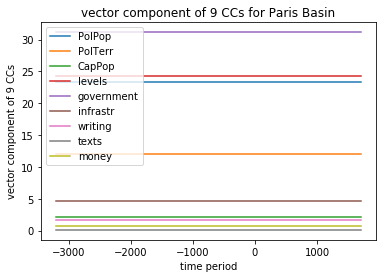

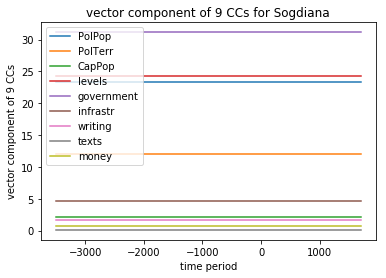

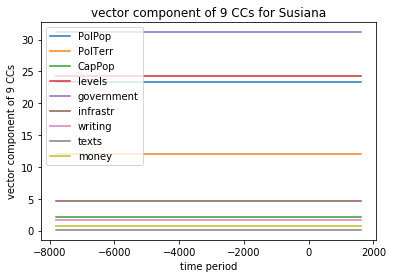

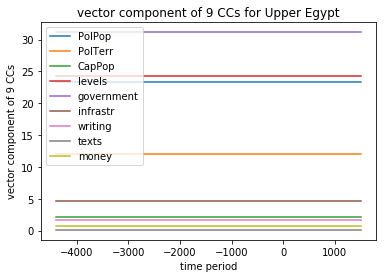

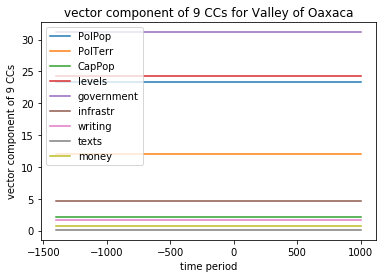

In [152]:
# Analysis on the effect of each variables for each NGA over time

#only NGAs with >= 100 data points
nga_grouped = pnas_data1[pnas_data1.groupby('NGA').NGA.transform(len) >= 100].groupby('NGA', as_index = False)

for nga, group in nga_grouped:
    time = group.Time.unique() # list of time periods for the iterated nga
    grouped = group.loc[:, features].values
    
    P, D, Q = svd(grouped)
    
    for i in range(9):
        vec_per = list() #list for the vectors of components
    
        for j in range(len(time)): 
            vec_per.append(Q[i])

        plt.plot(time, vec_per ,label= features[i])
    plt.xlabel('time period')
    plt.ylabel('vector component of 9 CCs')
    plt.title('vector component of 9 CCs for ' + str(nga))
    plt.legend(features, loc='upper left')
    plt.show()
    plt.close()

In [38]:
# diffusion map for the data matrix

data_mat = pnas_data1[pnas_data1.irep == 1].loc[:, features].values

#center the data
mean = np.mean(data_mat, axis=0)
data_mat -= mean

def sim(a,b):
    """
    Given two n-dim vectors a,b, compute the similarity as given by the euclidean norm distance 
    """
    return np.linalg.norm(a-b)


def adj(mat):
    """
    Compute the directed adjacency matrix using similarity function between two vectors
    """
    adj_mat = np.zeros((data_mat.shape[0], data_mat.shape[0]))

    for i in range(data_mat.shape[0]):

        sim_list = list()
        for j in range(data_mat.shape[0]):
            if i != j:
                sim_list.append(sim(data_mat[i], data_mat[j]))
        most_sim = np.argsort(sim_list)[:10] # top 10 vectors that are similar to one another 

        for k in range(len(most_sim)):
            adj_mat[i][most_sim[k]] = sim_list[k]
        
    return adj_mat

def laplacian(mat):
    """
    Given an adjacency matrix of a directed graph, compute the laplacian matrix 
    """
    return csgraph.laplacian(mat)

def job():
    adj_mat = adj(data_mat)
    lap_mat = laplacian(adj_mat)
#     print(lap_mat[:, :2])
    eig_val, eig_vec = np.linalg.eig(lap_mat)
        
    print((eig_vec[313]))

job()

    

    
    
        

[  0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
   0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
   0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
   0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
   0.00000000e+00 +0.00000000e+00j  -6.97876452e-06 +0.00000000e+00j
   3.25219862e-07 +0.00000000e+00j  -9.38340505e-07 -9.41333832e-08j
  -9.38340505e-07 +9.41333832e-08j   3.38674441e-05 +0.00000000e+00j
   7.67961548e-06 -1.37159709e-06j   7.67961548e-06 +1.37159709e-06j
   2.21915606e-05 -1.06359865e-05j   2.21915606e-05 +1.06359865e-05j
  -1.31731609e-05 +0.00000000e+00j  -2.98520132e-06 +5.94878385e-07j
  -2.98520132e-06 -5.94878385e-07j  -5.53890213e-06 +0.00000000e+00j
  -6.42168963e-07 +0.00000000e+00j  -1.60293232e-05 -1.41656934e-05j
  -1.60293232e-05 +1.41656934e-05j   2.50533159e-05 +6.22288338e-06j
   2.50533159e-05 -6.22288338e-06j  -5.18843383e-06 -7.16844621e-06j
  -5.18843383e-06 +7.16844621e-06j